In [1]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径
import sys
sys.path.append(r"C:\Users\haokw\Documents\GitHub\gaolu\MPC\高炉")
from base import    double_control_predict_result,\
                    gaolu_predict_raw,\
                    data_tranform_plot,\
                    get_y_aim_data,\
                    generate_yr,\
                    replace_outliers_with_weighted_diff

from base import MyRNNModel,CustomPredictor_double


In [2]:
# 读取Excel文件
excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据处理\\新输入输出模式\\简单插值数据-时间戳.xlsx'
df_sheet = pd.read_excel(excel_path, sheet_name='Sheet2') 
print(df_sheet.info())
print(df_sheet.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7398 entries, 0 to 7397
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   时间戳         7398 non-null   int64  
 1   Unnamed: 1  7398 non-null   int64  
 2   SI          7398 non-null   float64
 3   铁口1温度       7398 non-null   float64
 4   富氧流量        7398 non-null   float64
 5   冷风流量        7398 non-null   float64
 6   热风压力        7398 non-null   float64
 7   热风温度        7398 non-null   float64
 8   鼓风湿度        7398 non-null   float64
 9   设定喷煤量       7398 non-null   float64
 10  上小时喷煤量      7398 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 635.9 KB
None
Index(['时间戳', 'Unnamed: 1', 'SI', '铁口1温度', '富氧流量', '冷风流量', '热风压力', '热风温度',
       '鼓风湿度', '设定喷煤量', '上小时喷煤量'],
      dtype='object')


In [3]:
# 定义输入输出参数
input_term = ['富氧流量', '冷风流量', '热风压力', '热风温度', '鼓风湿度', '设定喷煤量', '上小时喷煤量']
output_term = ['铁口1温度', 'SI']
time_term= '时间戳'


C:\Users\haokw\AppData\Local\Temp\ipykernel_30392\3007301193.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haokw\AppData\Local\Temp\ipykernel_30392\3007301193.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haokw\AppData\Local\Temp\ipykernel_30392\3007301193.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haok

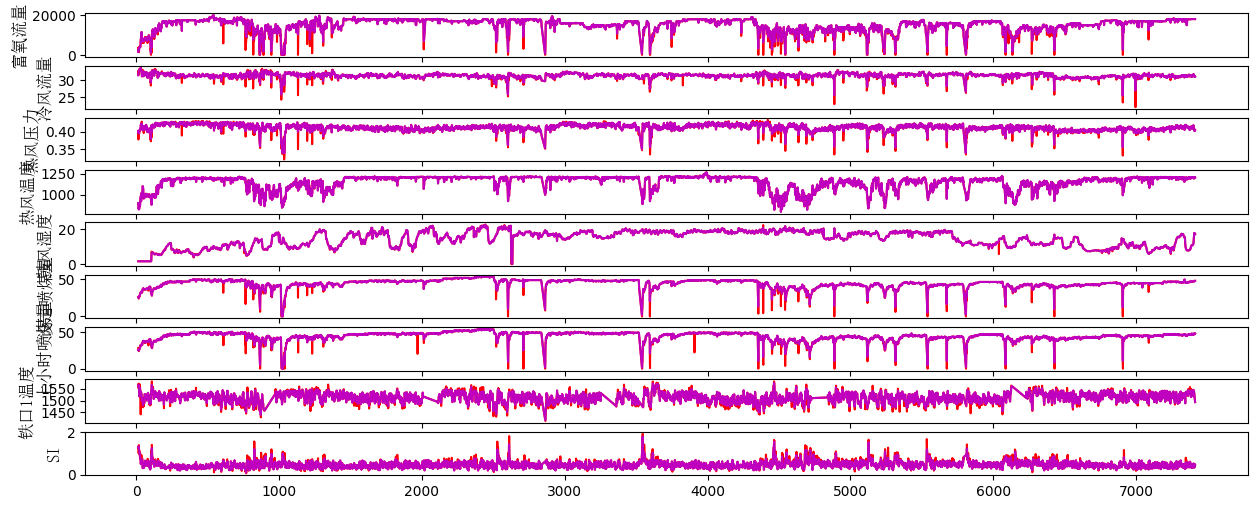

In [4]:
# 异常数据处理-处理前后对比
# 创建数据框副本以避免修改原始数据
df_sheet_process = df_sheet.copy()
# 定义一个函数，用前后两个值的差值按照距离进行加权替换异常值
def replace_outliers_with_weighted_diff(x, y):
    # 计算列的中位数
    median_value = y.median()
    # 检测异常值的索引
    outliers_index = (y - median_value).abs() > 1.5 * y.std()  # 使用标准差作为阈值
    
    # 遍历异常值的索引
    for idx in outliers_index[outliers_index].index:
        # 获取异常值前一个和后一个值的索引
        prev_idx = idx - 1 if idx - 1 >= 0 else idx
        next_idx = idx + 1 if idx + 1 < len(y) else idx
        # 计算当前 x 与前后两个 x 的距离
        dist_prev = abs(x[idx] - x[prev_idx])
        dist_next = abs(x[next_idx] - x[idx])
        total_dist = dist_prev + dist_next
        # 计算权重
        weight_prev = dist_next / total_dist
        weight_next = dist_prev / total_dist
        # 计算前后两个值的差值
        diff = y[next_idx] - y[prev_idx]
        # 根据权重进行插值
        interpolated_value = y[prev_idx] + weight_prev * diff
        # 用插值结果替代异常值
        y[idx] = interpolated_value




# 画出数据
def plot_subplot(data_x,data_y_yuan,data_y,column):
    plt.plot(data_x,data_y_yuan,'r-')
    plt.plot(data_x,data_y,'m-')
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签
    # 使用中文标签


# 对指定列应用替代异常值的函数
# 对指定列应用替代异常值的函数
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[0]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[1]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[2]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[4]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[5]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[6]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[output_term[0]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[output_term[1]])

plt.figure(figsize=(15, 6))
for idx, column in enumerate(input_term+output_term):
    
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_process[time_term].values,df_sheet[column].values,df_sheet_process[column].values,column)




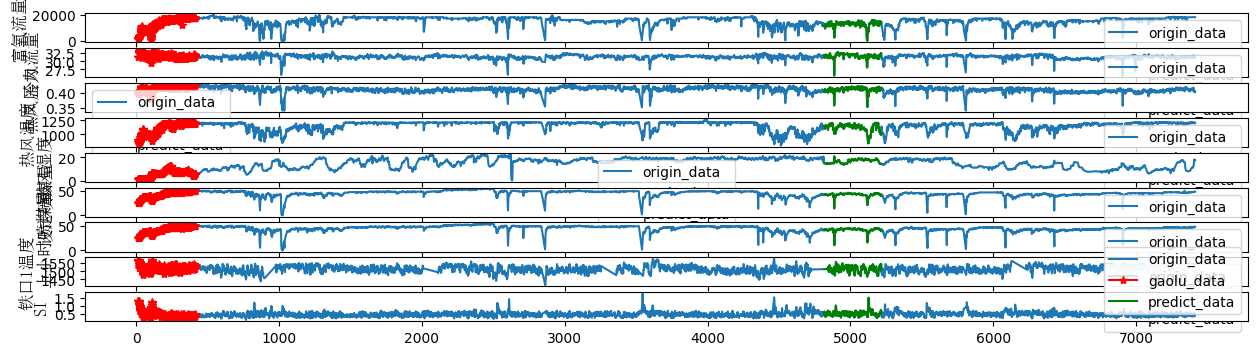

In [5]:
# 画出选取的数据
def plot_subplot(data_x,data_y,column,index_predict,index_gaolu):
    plt.plot(data_x,data_y,'-', label='origin_data')
    plt.plot(data_x[index_gaolu],data_y[index_gaolu],'r*-', label='gaolu_data')
    plt.plot(data_x[index_predict],data_y[index_predict],'g-', label='predict_data')
    plt.legend()
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签



length1 = 400
start1 = 0
length2 = 400
start2 = 4800


index_gaolu   = range(start1, start1+length1+1, 1)
index_predict     = range(start2, start2+length2+1, 1)
# index = range(1, 7572, 1)


plt.figure(figsize=(15, 4))
for idx, column in enumerate(input_term+output_term):
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_process[time_term].values,df_sheet_process[column].values,column,index_predict,index_gaolu)


In [6]:
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler

# 将数据存储为字典，每个键对应一列数据
original_data_dict = {
    input_term[0]:   df_sheet_process[input_term[0]].values,
    input_term[1]:   df_sheet_process[input_term[1]].values,
    input_term[2]:   df_sheet_process[input_term[2]].values,
    input_term[3]:   df_sheet_process[input_term[3]].values,
    input_term[4]:   df_sheet_process[input_term[4]].values,
    input_term[5]:   df_sheet_process[input_term[5]].values,
    input_term[6]:   df_sheet_process[input_term[6]].values,
    output_term[0]:  df_sheet_process[output_term[0]].values,
    output_term[1]:  df_sheet_process[output_term[1]].values
}

# 初始化缩放器
scalers = {}

# 进行拟合
for column, data in original_data_dict.items():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers[column] = scaler

# 进行归一化
normalized_data_dict = {}
for column, scaler in scalers.items():
    normalized_data_dict[column] = scaler.transform(original_data_dict[column].reshape(-1, 1)).flatten()

# 进行反归一化
original_data_dict = {}
for column, scaler in scalers.items():
    original_data_dict[column] = scaler.inverse_transform(normalized_data_dict[column].reshape(-1, 1)).flatten()


In [7]:
# 标定归一化前后数据
data_point = np.array([1500]).reshape(-1, 1)
data1 = scalers[output_term[0]].transform(data_point).flatten()

data_point = np.array(data1).reshape(-1, 1)
data2 = scalers[output_term[0]].inverse_transform(data_point).flatten()

data_point = np.array([1510]).reshape(-1, 1)
data3 = scalers[output_term[0]].transform(data_point).flatten()

data_point = np.array(data3).reshape(-1, 1)
data4 = scalers[output_term[0]].inverse_transform(data_point).flatten()

print(data1)
print(data2)
print(data3)
print(data4)
d_temp = (data3-data1)/(data4-data2)
print('每摄氏度的输出差：',d_temp)



data_point = np.array([0.50]).reshape(-1, 1)
data1 = scalers[output_term[1]].transform(data_point).flatten()

data_point = np.array(data1).reshape(-1, 1)
data2 = scalers[output_term[1]].inverse_transform(data_point).flatten()

data_point = np.array([0.60]).reshape(-1, 1)
data3 = scalers[output_term[1]].transform(data_point).flatten()

data_point = np.array(data3).reshape(-1, 1)
data4 = scalers[output_term[1]].inverse_transform(data_point).flatten()

print(data1)
print(data2)
print(data3)
print(data4)
d_yuansu = (data3-data1)/(data4-data2)
print('每0.01浓度的输出差：',(data3-data1))


[0.05471948]
[1500.]
[0.18042565]
[1510.]
每摄氏度的输出差： [0.01257062]
[-0.52854026]
[0.5]
[-0.40998065]
[0.6]
每0.01浓度的输出差： [0.11855962]


In [8]:
isShuffle = True
# isShuffle = False


In [9]:
# 组合训练数据--拆分训练、测试集
train_size = 0.7
val_size = 0.15
test_size = 0.15
# 构成    
# X = [X(t),X(t-1),Y(t-1)]
# Y = [Y(t)]
def make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,y1_data,y2_data):
    u1_data = u1_data
    u2_data = u2_data
    u3_data = u3_data
    u4_data = u4_data
    u5_data = u5_data
    u6_data = u6_data
    u7_data = u7_data

    y1_data = y1_data
    y2_data = y2_data

    X = np.column_stack((   u1_data  [1:-1], u2_data  [1:-1], u3_data  [1:-1], u4_data  [1:-1], u5_data  [1:-1], u6_data  [1:-1], u7_data  [1:-1],
                            u1_data  [0:-2], u2_data  [0:-2], u3_data  [0:-2], u4_data  [0:-2], u5_data  [0:-2], u6_data  [0:-2], u7_data  [0:-2],
                            y1_data  [0:-2], y2_data  [0:-2])
                        )
    y = np.column_stack((y1_data[1:-1],y2_data[1:-1]))

    # 使用 reshape 转换形状(457, 10) (457, 2)--->(457, 1, 10) (457, 1, 2)
    X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))
    y_reshaped = y.reshape((y.shape[0], 1, y.shape[1]))
    print('总数据数量：',y.shape)

    X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_reshaped, 
                                                        test_size=test_size, 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    # 将剩余的70%训练数据再次拆分成训练数据和验证数据（20%验证数据，50%训练数据）
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                        test_size=val_size/(train_size+val_size), 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    y_train = y_train.reshape((y_train.shape[0],y_train.shape[2]))
    y_val = y_val.reshape((y_val.shape[0],y_val.shape[2]))
    y_test = y_test.reshape((y_test.shape[0],y_test.shape[2]))
    print('训练数量：',X_train.shape,y_train.shape)
    print('验证数量：',X_val.shape,y_val.shape)
    print('测试数量：',X_test.shape,y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [10]:
# 高炉模型列数据
u1_data = normalized_data_dict[input_term[0]][index_gaolu]
u2_data = normalized_data_dict[input_term[1]][index_gaolu]
u3_data = normalized_data_dict[input_term[2]][index_gaolu]
u4_data = normalized_data_dict[input_term[3]][index_gaolu]
u5_data = normalized_data_dict[input_term[4]][index_gaolu]
u6_data = normalized_data_dict[input_term[5]][index_gaolu]
u7_data = normalized_data_dict[input_term[6]][index_gaolu]
y1_data = normalized_data_dict[output_term[0]][index_gaolu]
y2_data = normalized_data_dict[output_term[1]][index_gaolu]
num_samples = y1_data.shape[0]
print('高炉模型数据')
X_gaolu_train, X_gaolu_val, X_gaolu_test,\
y_gaolu_train, y_gaolu_val, y_gaolu_test = make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,y1_data,y2_data)

# 预测模型列数据
u1_data = normalized_data_dict[input_term[0]][index_predict]
u2_data = normalized_data_dict[input_term[1]][index_predict]
u3_data = normalized_data_dict[input_term[2]][index_predict]
u4_data = normalized_data_dict[input_term[3]][index_predict]
u5_data = normalized_data_dict[input_term[4]][index_predict]
u6_data = normalized_data_dict[input_term[5]][index_predict]
u7_data = normalized_data_dict[input_term[6]][index_predict]
y1_data = normalized_data_dict[output_term[0]][index_predict]
y2_data = normalized_data_dict[output_term[1]][index_predict]
num_samples = y1_data.shape[0]
print('预测模型数据')
X_predict_train, X_predict_val, X_predict_test,\
y_predict_train, y_predict_val, y_predict_test = make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,y1_data,y2_data)


高炉模型数据
总数据数量： (399, 2)
训练数量： (279, 1, 16) (279, 2)
验证数量： (60, 1, 16) (60, 2)
测试数量： (60, 1, 16) (60, 2)
预测模型数据
总数据数量： (399, 2)
训练数量： (279, 1, 16) (279, 2)
验证数量： (60, 1, 16) (60, 2)
测试数量： (60, 1, 16) (60, 2)


In [11]:
# 定义LSTM模型
import torch
import torch.nn as nn
import torch.optim as optim

class MyRNNModel(torch.nn.Module):
    def __init__(self,features_size,hidden_size,isbidirectional):
        super(MyRNNModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=features_size,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=isbidirectional
        )
        if isbidirectional:
            self.fc = nn.Linear(2 * hidden_size, 2)
        else:
            self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        
        last_lstm_output = lstm_out[:, -1, :]
        # print(last_lstm_output)
        output = self.fc(last_lstm_output)
        
        return output

    def custom_loss(self, y_true, y_pred):
        squared_diff = torch.pow(y_true - y_pred, 2)
        sum_squared_diff = torch.sum(squared_diff)
        mse = sum_squared_diff / len(y_true)
        return mse



    def my_fit(self, 
                X_train, y_train, 
                X_val, y_val, 
                train_loss_list,val_loss_list,
                epochs=1, batch_size=32, lr=0.001):
        optimizer = optim.Adam(self.parameters(), lr=lr)


        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, len(X_train), batch_size):
                x_batch = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
                y_batch = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

                optimizer.zero_grad()
                y_pred = self(x_batch)
                loss = self.custom_loss(y_batch, y_pred)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            average_epoch_train_loss = epoch_loss / (len(X_train) / batch_size)
            # 验证集评估
            self.eval()
            with torch.no_grad():
                val_loss = 0
                for i in range(0, len(X_val), batch_size):
                    x_batch_val = torch.tensor(X_val[i:i+batch_size], dtype=torch.float32)
                    y_batch_val = torch.tensor(y_val[i:i+batch_size], dtype=torch.float32)

                    y_pred_val = self(x_batch_val)
                    val_loss += self.custom_loss(y_batch_val, y_pred_val).item()

                average_epoch_val_loss = val_loss / (len(X_val) / batch_size)

            print(f'第 {epoch + 1}/{epochs} 轮, 训练误差: {average_epoch_train_loss:.4f}, 验证误差: {average_epoch_val_loss:.4f}', end='\r')
            train_loss_list.append(average_epoch_train_loss)
            val_loss_list.append(average_epoch_val_loss)

        return train_loss_list,val_loss_list
    
    

    def my_predict(self, X_test):
        # 设置模型为评估模式，这会关闭 dropout 等层
        self.eval()
        # 将输入数据转换为张量，并设置 requires_grad=True
        x_tensor = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
        
        # 获取模型的预测输出
        y_pred = self(x_tensor)
        # 保留预测值的梯度信息
        y_pred.retain_grad()
        # 返回预测结果和包含梯度信息的张量
        return y_pred[:,0].detach().numpy(),y_pred[:,1].detach().numpy()


In [12]:
epoch_once_time = 25


In [13]:
# 建立高炉模型实例
features_size = 16
hidden_size = 16
# 设置随机种子
# torch.manual_seed(0)
model_gaolu = MyRNNModel(features_size = features_size, 
                        hidden_size = hidden_size,
                        isbidirectional=True)
epoch_sum_gaolu = 0
gaolu_train_loss_list = []
gaolu_val_loss_list = []


第 25/25 轮, 训练误差: 0.0180, 验证误差: 0.0260
epoch_sum: 25


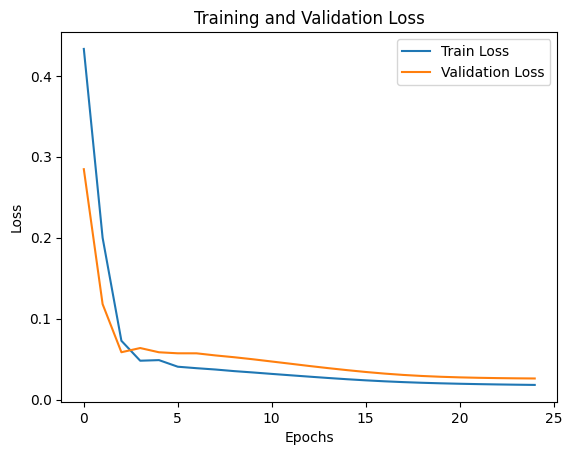

In [14]:
# 高炉模型训练
epoch_once = epoch_once_time
epoch_sum_gaolu = epoch_sum_gaolu + epoch_once
gaolu_train_loss_list,gaolu_val_loss_list = model_gaolu.my_fit(X_gaolu_train, y_gaolu_train,
                                    X_gaolu_val, y_gaolu_val, 
                                    gaolu_train_loss_list, gaolu_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=32,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_gaolu)

# 绘制训练和验证损失曲线
plt.plot(gaolu_train_loss_list, label='Train Loss')
plt.plot(gaolu_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



RMSE:  铁口1温度: 9.7110 , SI: 0.0972 
MAPE:  铁口1温度: 0.5169% , SI: 18.5476%
MRE :  铁口1温度: 0.0052  , SI: 0.1855 
per :  铁口1温度: 0.6833  , SI: 0.7333 


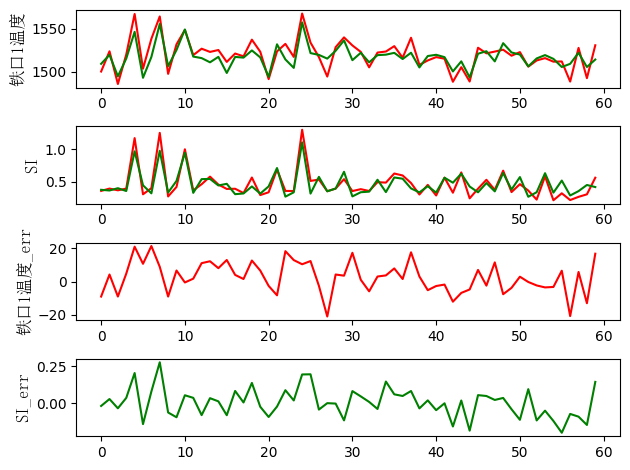

In [15]:
# 高炉模型预测
y_pred_0,y_pred_1  = model_gaolu.my_predict(X_gaolu_test)
# 计算 RMSE、MRE
y_test = y_gaolu_test
# y_test = y_test[:70]
# y_pred_0 = y_pred_0[:70]
# y_pred_1 = y_pred_1[:70]

double_control_predict_result(scalers,output_term,y_test,y_pred_0,y_pred_1)


In [16]:
# 创建预测模型实例
features_size = 16
hidden_size_predict = 16
# 设置随机种子
torch.manual_seed(0)
model = MyRNNModel(features_size = features_size, 
                    hidden_size = hidden_size_predict,
                    isbidirectional=True)
epoch_sum_predict = 0
predict_train_loss_list = []
predict_val_loss_list = []


第 25/25 轮, 训练误差: 0.0427, 验证误差: 0.0407
epoch_sum: 0


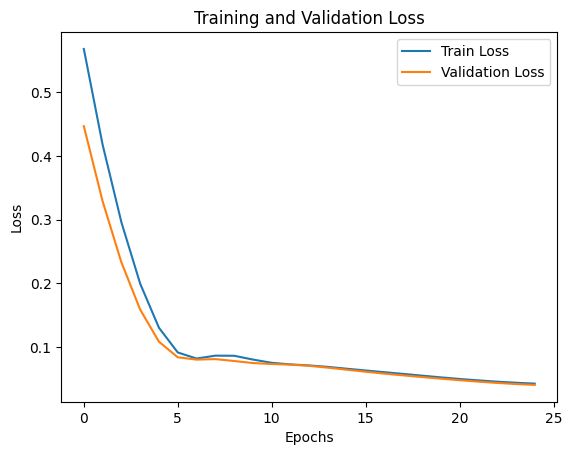

In [17]:
# 预测模型训练
epoch_once = epoch_once_time
epoch_sum = epoch_sum_predict + epoch_once
predict_train_loss_list, predict_val_loss_list = model.my_fit(X_predict_train, y_predict_train,
                                    X_predict_val, y_predict_val, 
                                    predict_train_loss_list, predict_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=64,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_predict)


# 绘制训练和验证损失曲线
plt.plot(predict_train_loss_list, label='Train Loss')
plt.plot(predict_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


RMSE:  铁口1温度: 10.7475 , SI: 0.1126 
MAPE:  铁口1温度: 0.5637% , SI: 17.5319%
MRE :  铁口1温度: 0.0056  , SI: 0.1753 
per :  铁口1温度: 0.6500  , SI: 0.6833 


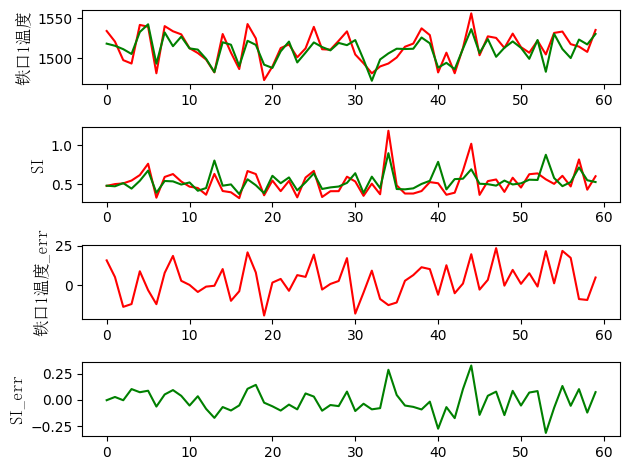

In [18]:
# 预测模型预测
y_pred_0,y_pred_1  = model.my_predict(X_predict_test)

# 计算 RMSE、MRE
y_test = y_predict_test

double_control_predict_result(scalers,output_term,y_test,y_pred_0,y_pred_1)



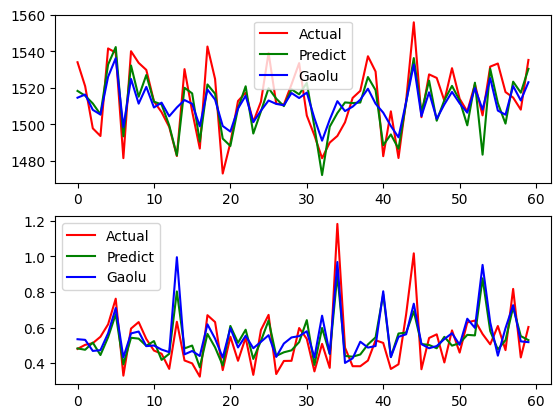

In [19]:
# 高炉、预测、原始对比
gaolu_predict_raw(scalers,output_term,model,model_gaolu,X_predict_test,y_predict_test)


In [20]:
iscontrol = True
# iscontrol = False


In [21]:
# 自定义预测
model_predict = model
hidden_size = hidden_size_predict
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def lstm_forward(input, initial_states, w_ih, w_hh, b_ih, b_hh):
    h_0, c_0 = initial_states  # 初始状态  [b_size, hidden_size]
    b_size, seq_len, input_size = input.shape
    h_size = h_0.shape[-1]

    h_prev, c_prev = h_0, c_0

    # 使用 np.newaxis 在第一个维度上插入一个新的维度  # 使用 np.tile 在第一个维度上复制 b_size 次
    w_ih_expanded = w_ih[np.newaxis, :, :]    
    w_ih_batch = np.tile(w_ih_expanded, (b_size, 1, 1))
    w_hh_expanded = w_hh[np.newaxis, :, :]    
    w_hh_batch = np.tile(w_hh_expanded, (b_size, 1, 1))
    # print(w_ih_batch.shape)

    output_size = h_size
    output = np.zeros((b_size, seq_len, output_size))  # 初始化一个输出序列
    for t in range(seq_len):
        x = input[:, t, :]  # 当前时刻的输入向量 [b,in_size]->[b,in_size,1]
        w_times_x = np.matmul(w_ih_batch, x[:, :, np.newaxis]).squeeze(-1)   # bmm:含有批量大小的矩阵相乘
        # [b, 4*hidden_size, 1]->[b, 4*hidden_size]
        # 这一步就是计算了 Wii*xt|Wif*xt|Wig*xt|Wio*xt
        w_times_h_prev = np.matmul(w_hh_batch, h_prev[:, :, np.newaxis]).squeeze(-1)
        # [b, 4*hidden_size, hidden_size]*[b, hidden_size, 1]->[b,4*hidden_size, 1]->[b, 4*hidden_size]
        # 这一步就是计算了 Whi*ht-1|Whf*ht-1|Whg*ht-1|Who*ht-1

        # 分别计算输入门(i)、遗忘门(f)、cell门(g)、输出门(o)  维度均为 [b, h_size]
        i_t = sigmoid(w_times_x[:, :h_size] + w_times_h_prev[:, :h_size] + b_ih[:h_size] + b_hh[:h_size])  # 取前四分之一
        f_t = sigmoid(w_times_x[:, h_size:2*h_size] + w_times_h_prev[:, h_size:2*h_size]
                            + b_ih[h_size:2*h_size] + b_hh[h_size:2*h_size])
        g_t = np.tanh(w_times_x[:, 2*h_size:3*h_size] + w_times_h_prev[:, 2*h_size:3*h_size]
                            + b_ih[2*h_size:3*h_size] + b_hh[2*h_size:3*h_size])
        o_t = sigmoid(w_times_x[:, 3*h_size:] + w_times_h_prev[:, 3*h_size:]
                            + b_ih[3*h_size:] + b_hh[3*h_size:])
        c_prev = f_t * c_prev + i_t * g_t
        h_prev = o_t * np.tanh(c_prev)

        output[:, t, :] = h_prev

    return output, (np.expand_dims(h_prev, axis=0), np.expand_dims(c_prev, axis=0))  # 官方是三维，在第0维扩一维



def predict_my(data_input):

    input = data_input  # 随机初始化一个输入序列
    c_0 = np.zeros((data_input.shape[0], hidden_size))  # 初始值，不会参与训练
    h_0 = np.zeros((data_input.shape[0], hidden_size))

    output_forward, (h_n_me, c_n_me) = lstm_forward(input, (h_0, c_0), 
                                                model_predict.lstm.weight_ih_l0.detach().numpy(),
                                                model_predict.lstm.weight_hh_l0.detach().numpy(), 
                                                model_predict.lstm.bias_ih_l0.detach().numpy(), 
                                                model_predict.lstm.bias_hh_l0.detach().numpy())

    last_lstm_output_forward = output_forward[:, -1, :]

    output_backward, (h_n_me, c_n_me) = lstm_forward(input, (h_0, c_0), 
                                                model_predict.lstm.weight_ih_l0_reverse.detach().numpy(),
                                                model_predict.lstm.weight_hh_l0_reverse.detach().numpy(), 
                                                model_predict.lstm.bias_ih_l0_reverse.detach().numpy(), 
                                                model_predict.lstm.bias_hh_l0_reverse.detach().numpy())

    last_lstm_output_backward = output_backward[:, -1, :]
    # print(last_lstm_output_forward.shape)
    # print(last_lstm_output_backward.shape)
    # 最终输出
    combined_hidden = np.concatenate((last_lstm_output_forward, last_lstm_output_backward), axis=1)
    # print(combined_hidden.shape)


    output = (np.dot(combined_hidden, np.transpose(model_predict.fc.weight.detach().numpy()))
                + model_predict.fc.bias.detach().numpy()
)
    y_pred_0, y_pred_1= output[:,0],output[:,1]

    # y_pred_0 = scalers[output_term[0]].inverse_transform(np.array(y_pred_0).reshape(-1, 1)).flatten()
    # y_pred_1 = scalers[output_term[1]].inverse_transform(np.array(y_pred_1).reshape(-1, 1)).flatten()




    return y_pred_0, y_pred_1


y_pred_0, y_pred_1= predict_my(X_predict_test)


# plot_hit_rate_curve(y_test, y_pred_0, y_pred_1)
# plot_hit_rate_curve(y_test, y_pred_0.detach().numpy(), y_pred_1.detach().numpy())


In [22]:
# 生成期望数据
Times = 100

def generate_y_aim_data(Times):

    set_y1 = np.full(Times,1500)
    set_y1[30:] = 1510
    set_y1[60:] = 1505
    set_y1[90:] = 1515
    # set_y1[70:] = 1520
    # set_y1[90:] = 1525

    set_y2 = np.full(Times,0.44)
    set_y2[15:] = 0.48
    set_y2[45:] = 0.52
    set_y2[75:] = 0.44
    # 限制设定值在 -1 到 1 之间
    # set_y1 = np.clip(set_y1, -1, 1)
    # set_y2 = np.clip(set_y2, -1, 1)


    set_y1_trans = scalers[output_term[0]].transform(set_y1.reshape(-1,1)).flatten()
    set_y2_trans = scalers[output_term[1]].transform(set_y2.reshape(-1,1)).flatten()

    return set_y1, set_y2, set_y1_trans, set_y2_trans

# # 调用示例
# set_y1, set_y2, set_y1_trans, set_y2_trans= generate_y_aim_data(Times)
# plt.plot(set_y1_trans)
# plt.plot(set_y2_trans)
# plt.title('y_sp')
# plt.show()



In [23]:
# 生成参考轨迹
def get_yr(aim_value,current_value,alpha,P):
    # 生成设定信号
    setpoint_signal = np.full(10, aim_value)
    # 初始化参数
    alpha = alpha
    y_r = np.zeros(P)
    y_r[0] = current_value
    # 模拟一阶模型
    for k in range(1,P):
        y_r[k] = alpha * y_r[k-1] + (1 - alpha) * aim_value

    # # 绘制结果
    # plt.plot(setpoint_signal, label='Setpoint Signal')
    # plt.plot(y_r,'o-', label='Output Signal (Tracked)')
    # plt.legend()
    # plt.xlabel('Time')
    # plt.ylabel('Amplitude')
    # plt.title('Tracking Setpoint Signal with One-Order Model')
    # plt.show()
    return y_r
# 测试
y_r = get_yr(1,-0.5,0.667,5+1)


In [24]:
#生成控制时域的数据格式
def generate_k_data(u1_data, u2_data, u3_data, u4_data, u5_data, u6_data, u7_data, y1_data,y2_data, num_samples, P):
    nearest_index = np.abs(y1_data - (-0.5)).argmin()
    # 生成随机索引值
    #从原有数据的randint时刻开始往下进行控制
    randint = np.random.randint(1, num_samples - 2 - P - 1)
    randint = nearest_index  # 如果你希望使用固定的值而不是随机生成
    # randint = 250  # 如果你希望使用固定的值而不是随机生成
    print(randint)
    # 提取数据并构成 k_data
    # 第一次得到下面五个变量，固定好格式构成k_data
    u1   = u1_data[randint  :randint+3  ]
    u2   = u2_data[randint  :randint+3  ]
    u3   = u3_data[randint  :randint+3  ]
    u4   = u4_data[randint  :randint+3  ]
    u5   = u2_data[randint  :randint+3  ]
    u6   = u3_data[randint  :randint+3  ]
    u7   = u4_data[randint  :randint+3  ]

    y1   = y1_data[randint  :randint+3  ]
    y2   = y2_data[randint  :randint+3  ]
    k_data = np.concatenate((u1, u2, u3, u4, u5, u6, u7, y1, y2), axis=0)
    print(k_data.shape)

    k_data = np.zeros_like(k_data)
    return k_data



In [25]:
# 定义单时刻的MPC问题优化
def my_MPC(k_data,params,M,P,y1_aim,y2_aim,isprint):
    h1 = 1.0
    h2 = 1.0
    lamda1 = 0.001
    lamda2 = 0.001
    lamda3 = 0.001
    lamda4 = 0.001
    y1_percent = 1.0
    y2_percent = 1.0

    # 从固定格式k_data里面读取信息
    u1   = k_data[0:3]
    u2   = k_data[3:6]
    u3   = k_data[6:9]
    u4   = k_data[9:12]
    u5   = k_data[12:15]
    u6   = k_data[15:18]
    u7   = k_data[18:21]

    y1   = k_data[21:24]
    y2   = k_data[24:27]

    
    # 获取猜测值[h U1 U2]
    # h, U1, U2  =params[0], params[1:M+1],params[M+1:]
    U1, U2, U3, U4, U5, U6, U7  =params[0:M], params[M:2*M],params[2*M:3*M], params[3*M:4*M], params[4*M:5*M],params[5*M:6*M], params[6*M:7*M]
    
    # 整理数据见   MPC推到.escel
    u1   = np.concatenate((u1,U1,U1[-1]*np.ones(P-M)))
    u2   = np.concatenate((u2,U2,U2[-1]*np.ones(P-M)))
    u3   = np.concatenate((u3,U3,U3[-1]*np.ones(P-M)))
    u4   = np.concatenate((u4,U4,U4[-1]*np.ones(P-M)))
    u5   = np.concatenate((u5,U5,U5[-1]*np.ones(P-M)))
    u6   = np.concatenate((u6,U6,U6[-1]*np.ones(P-M)))
    u7   = np.concatenate((u7,U7,U7[-1]*np.ones(P-M)))
    y1   = np.concatenate((y1,np.zeros(P)))
    y2   = np.concatenate((y2,np.zeros(P)))
    if isprint:
        print(u1.round(4))
        print(u2.round(4))
        print(u3.round(4))
        print(u4.round(4))
        print(u5.round(4))
        print(u6.round(4))
        print(u7.round(4))
        print(y1.round(4))    
        print(y2.round(4))
        print('开始预测')

    y1_k = y1[2]
    y2_k = y2[2]





    # 总共预测 P+1 次
    # 对k时刻进行预测-----1次
    for j in range(1):   # j = 0
        x = np.column_stack((   u1[j+2],u2[j+2],u3[j+2],u4[j+2],u5[j+2],u6[j+2],u7[j+2],
                                u1[j+1],u2[j+1],u3[j+1],u4[j+1],u5[j+1],u6[j+1],u7[j+1],
                                y1[j+1],y2[j+1]))
        x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_m_k, y2_m_k = predict_my(x)
        E1_k = y1_k - y1_m_k
        E2_k = y2_k - y2_m_k
        if isprint:
            print(j,'mode = 0')
            print(x.round(4))
            print(y1_k.round(4),y2_k.round(4))
            print(y1_m_k.round(4),y2_m_k.round(4))

    # 对控制时刻进行预测-----M次
    for j in range(1,M+1):  # j = 1,2
        x = np.column_stack((   u1[j+2],u2[j+2],u3[j+2],u4[j+2],u5[j+2],u6[j+2],u7[j+2],
                                u1[j+1],u2[j+1],u3[j+1],u4[j+1],u5[j+1],u6[j+1],u7[j+1],
                                y1[j+1],y2[j+1]))
        x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_k_j, y2_k_j = predict_my(x)
        y1[j+2] = y1_k_j.item()
        y2[j+2] = y2_k_j.item()
        if isprint:
            print(j,'mode = 1')
            print(x.round(4))
            print(y1_k_j.round(4),y2_k_j.round(4))
            print('更新后:')
            print(u1.round(4))
            print(u2.round(4))
            print(u3.round(4))
            print(u4.round(4))
            print(u5.round(4))
            print(u6.round(4))
            print(u7.round(4))
            print(y1.round(4))    
            print(y2.round(4))

    # 对控制时域外的部分进行预测-----P-M次
    # 注意：这部分的信号是保持控制不变下进行
    for j in range(M+1,P+1):  #j = 3,4
        x = np.column_stack((   u1[j+2],u2[j+2],u3[j+2],u4[j+2],u5[j+2],u6[j+2],u7[j+2],
                                u1[j+1],u2[j+1],u3[j+1],u4[j+1],u5[j+1],u6[j+1],u7[j+1],
                                y1[j+1],y2[j+1]))
        x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_k_j, y2_k_j = predict_my(x)
        y1[j+2] = y1_k_j.item()#将预测值作为下一步的输出值
        y2[j+2] = y2_k_j.item()
        if isprint:
            print(j,'mode = 2')
            print(x.round(4))
            print(y1_k_j.round(4),y2_k_j.round(4))
            print('更新后:')
            print(u1.round(4))
            print(u2.round(4))
            print(u3.round(4))
            print(u4.round(4))
            print(u5.round(4))
            print(u6.round(4))
            print(u7.round(4))
            print(y1.round(4))    
            print(y2.round(4))



    k_data2 = np.concatenate((u1[1:4],u2[1:4],u3[1:4],u4[1:4],u5[1:4],u6[1:4],u7[1:4],y1[1:4],y2[1:4]),axis=0)
    if isprint:
        print('更新k_data')
        print(k_data2.round(4))


    #获取参考轨迹
    # 一定要对照好做差的序列
    y1_r_aim  = get_yr(y1_aim,y1_k,0.1,P+1)
    y1_r = y1_r_aim[1:] 


    y2_r_aim  = get_yr(y2_aim,y2_k,0.1,P+1)
    y2_r = y2_r_aim[1:] 

    y1_M_k = y1[3:]
    y2_M_k = y2[3:]
    if isprint==1:
        print('反馈补偿:')
        print('y1_k',y1_k.round(4))  
        print('y1_m_k',y1_m_k.round(4))    
        print('h*E1_k',(h1*E1_k).round(4)) 
        print('y2_k',y2_k.round(4))  
        print('y2_m_k',y2_m_k.round(4))   
        print('h*E2_k',(h2*E2_k).round(4))

        print('temp:')
        print('y1_aim',y1_aim.round(4))
        print('y1_r_aim',y1_r_aim.round(4))
        print('y1_r',y1_r.round(4))
        print('y1_M_k',y1_M_k.round(4))
        print('y1_M_k+h1*E1_k',(y1_M_k+h1*E1_k).round(4))

        print('Si_percent:')
        print('y2_aim',y2_aim.round(4))
        print('y2_r_aim',y2_r_aim.round(4))
        print('y2_r',y2_r.round(4))
        print('y2_M_k',y2_M_k.round(4))
        print('y2_M_k+h2*E2_k',(y2_M_k+h2*E2_k).round(4))

        print('u:')
        print(u1[2:].round(4))
        print(u2[2:].round(4))
        print(u3[2:].round(4))
        print(u4[2:].round(4))
        
    # 计算mse
    # lamda1太大的话会导致y1_r和y1_M_k的误差加大*****************导致超调的原因\与目标值之间存在间隙


    # y1_err = y1_percent*np.sum((y1_r-(y1_M_k+h1*E1_k))**2) 
    # y2_err = y2_percent*np.sum((y2_r-(y2_M_k+h2*E2_k))**2) 
    # u1_power = lamda1*np.sum((np.diff(u1[2:]))**2)
    # u2_power = lamda2*np.sum((np.diff(u2[2:]))**2)
    # u3_power = lamda3*np.sum((np.diff(u3[2:]))**2)
    # u4_power = lamda4*np.sum((np.diff(u4[2:]))**2)
    # u5_power = lamda2*np.sum((np.diff(u5[2:]))**2)
    # u6_power = lamda3*np.sum((np.diff(u6[2:]))**2)
    # u7_power = lamda4*np.sum((np.diff(u7[2:]))**2)

    y1_err = y1_percent*np.sum(np.fabs(y1_r-(y1_M_k+h1*E1_k))) 
    y2_err = y2_percent*np.sum(np.fabs(y2_r-(y2_M_k+h2*E2_k))) 
    u1_power = lamda1*np.sum((np.fabs(np.diff(u1))))
    u2_power = lamda2*np.sum((np.fabs(np.diff(u2))))
    u3_power = lamda3*np.sum((np.fabs(np.diff(u3))))
    u4_power = lamda4*np.sum((np.fabs(np.diff(u4))))
    u5_power = lamda2*np.sum((np.fabs(np.diff(u5))))
    u6_power = lamda3*np.sum((np.fabs(np.diff(u6))))
    u7_power = lamda4*np.sum((np.fabs(np.diff(u7))))

    mse = (0
            +y1_err
            +y2_err
            +u1_power
            +u2_power
            +u3_power
            +u4_power
            +u5_power
            +u6_power
            +u7_power
            )
    
    # print('mse {:.7f}'.format(mse))
    if isprint==1:
        print('mse {:.7f}'.format(mse))
        print('1111 {:.7f}'.format(y1_err))
        print('2222 {:.7f}'.format(y2_err))
        print('1111 {:.7f}'.format(u1_power))
        print('2222 {:.7f}'.format(u2_power))
        print('3333 {:.7f}'.format(u3_power))
        print('4444 {:.7f}'.format(u4_power))



    return mse , k_data2, E1_k*h1,  E2_k*h2
    # return mse , k_data2, E1_k*h1


In [26]:
Times = 100


In [27]:
# 对未来Times周期预测控制
max_control = 1.0
# 期望设定值
set_y1, set_y2, set_y1_trans, set_y2_trans = generate_y_aim_data(Times)

# MPC参数
P = 4  # 预测时域长度  增大P能平稳些
M = 2  # 控制时域长度
#生成控制时域的数据格式
k_data = generate_k_data(u1_data, u2_data, u3_data, u4_data, u5_data, u6_data, u7_data, 
                        y1_data, y2_data, num_samples, P)


# MPC控制循环   迭代的只有：k_data
all_pred_y1 = []
all_pred_y2 = []
all_pred_u1 = []
all_pred_u2 = []
all_pred_u3 = []
all_pred_u4 = []
all_pred_u5 = []
all_pred_u6 = []
all_pred_u7 = []
# MPC控制循环40
for k in range(Times):
    if iscontrol == False:
        break

    print(f"这是对第{k}时刻的最优U1、U2输入求解")

    # 定义优化目标函数
    def objective_function(params, *k_data):
        mse, k_data2, E1_k_0, E2_k_0 = my_MPC(k_data=k_data[0], params=params, 
                                M=M, P=P, 
                                y1_aim = set_y1_trans[k], y2_aim = set_y2_trans[k],
                                isprint = 0) 
        return mse
    
    # 初始猜测值[h U1 U2]   定义参数的上下限    设置退出条件
    params = np.concatenate([np.ones(M), np.ones(M),np.ones(M), np.ones(M), np.ones(M),np.ones(M), np.ones(M)])
    bounds = [(-max_control, max_control) for _ in range(7 * M)]
    exit_conditions = {'maxiter': 1000} 
    # 进行优化
    result = minimize(objective_function, params, method='L-BFGS-B', 
                    bounds=bounds, args=k_data)#args传进来的是一个元组


    U1, U2, U3, U4, U5, U6, U7 =    result.x[0:M], result.x[M:2*M], \
                                    result.x[2*M:3*M], result.x[3*M:4*M], \
                                    result.x[4*M:5*M], result.x[5*M:6*M], \
                                    result.x[6*M:7*M]
    

    u1   = k_data[0:3]
    u2   = k_data[3:6]
    u3   = k_data[6:9]
    u4   = k_data[9:12]
    u5   = k_data[12:15]
    u6   = k_data[15:18]
    u7   = k_data[18:21]

    y1   = k_data[21:24]
    y2   = k_data[24:27]
    u1   = np.concatenate((u1,U1,U1[-1]*np.ones(P-M)))
    u2   = np.concatenate((u2,U2,U2[-1]*np.ones(P-M)))
    u3   = np.concatenate((u3,U3,U3[-1]*np.ones(P-M)))
    u4   = np.concatenate((u4,U4,U4[-1]*np.ones(P-M)))
    u5   = np.concatenate((u5,U5,U5[-1]*np.ones(P-M)))
    u6   = np.concatenate((u6,U6,U6[-1]*np.ones(P-M)))
    u7   = np.concatenate((u7,U7,U7[-1]*np.ones(P-M)))
    y1   = np.concatenate((y1,np.zeros(P)))
    y2   = np.concatenate((y2,np.zeros(P)))



    # 将控制序列第一个数作用于高炉
    j = 1
    x = np.column_stack((   u1[j+2],u2[j+2],u3[j+2],u4[j+2],u5[j+2],u6[j+2],u7[j+2],
                            u1[j+1],u2[j+1],u3[j+1],u4[j+1],u5[j+1],u6[j+1],u7[j+1],
                            y1[j+1],y2[j+1]))
    x = x.reshape((x.shape[0], 1, x.shape[1]))
    y1_pred0, y2_pred0 = model.my_predict(x)
    y1_pred, y2_pred = model_gaolu.my_predict(x)
    


    # 更新k_data
    params = np.concatenate((U1, U2, U3, U4, U5, U6, U7),axis=0)
    mse, k_data2, E1_k_0, E2_k_0 =my_MPC(k_data=k_data,params=params,
                            M=M,P=P, 
                            y1_aim = set_y1_trans[k], y2_aim = set_y2_trans[k],
                            isprint = 0) 


    print(  '1设定',set_y1_trans[k].round(4),\
            '预测',y1_pred0.round(4),\
            '高炉', y1_pred.round(4),\
            '高炉与设定误差',(set_y1_trans[k]-y1_pred).round(4),(set_y1_trans[k]-y1_pred).round(4)/d_temp,\
            '模型误差',(y1_pred0 - y1_pred).round(4),\
            '校正值',E1_k_0.round(4))
    print(  '2设定',set_y2_trans[k].round(4),\
            '预测',y2_pred0.round(4),\
            '高炉', y2_pred.round(4),\
            '高炉与设定误差',(set_y2_trans[k]-y2_pred).round(4),(set_y2_trans[k]-y2_pred).round(4)/d_yuansu,\
            '模型误差',(y2_pred0 - y2_pred).round(4),\
            '校正值',E2_k_0.round(4))



    all_pred_y1.append(y1_pred)
    all_pred_y2.append(y2_pred)
    all_pred_u1.append(U1[0])
    all_pred_u2.append(U2[0])
    all_pred_u3.append(U3[0])
    all_pred_u4.append(U4[0])
    all_pred_u5.append(U5[0])
    all_pred_u6.append(U6[0])
    all_pred_u7.append(U7[0])
    k_data2[23] = y1_pred.item()
    k_data2[26] = y2_pred.item()
    k_data = k_data2
    # 进入下一时刻，更新预测时域、控制时域，即k_data


302
(27,)
这是对第0时刻的最优U1、U2输入求解
1设定 0.0547 预测 [0.2008] 高炉 [0.1455] 高炉与设定误差 [-0.0908] [-7.22319324] 模型误差 [0.0553] 校正值 [-0.1083]
2设定 -0.5997 预测 [-0.4362] 高炉 [-0.3152] 高炉与设定误差 [-0.2844] [-0.2398793] 模型误差 [-0.1209] 校正值 [0.0684]
这是对第1时刻的最优U1、U2输入求解
1设定 0.0547 预测 [0.14] 高炉 [0.1358] 高炉与设定误差 [-0.0811] [-6.45155255] 模型误差 [0.0042] 校正值 [-0.0553]
2设定 -0.5997 预测 [-0.6851] 高炉 [-0.5606] 高炉与设定误差 [-0.039] [-0.03289484] 模型误差 [-0.1244] 校正值 [0.1209]
这是对第2时刻的最优U1、U2输入求解
1设定 0.0547 预测 [0.0997] 高炉 [0.1516] 高炉与设定误差 [-0.0969] [-7.70845172] 模型误差 [-0.052] 校正值 [-0.0042]
2设定 -0.5997 预测 [-0.7176] 高炉 [-0.5645] 高炉与设定误差 [-0.0352] [-0.0296897] 模型误差 [-0.1531] 校正值 [0.1244]
这是对第3时刻的最优U1、U2输入求解
1设定 0.0547 预测 [0.0586] 高炉 [0.1326] 高炉与设定误差 [-0.0779] [-6.19699052] 模型误差 [-0.074] 校正值 [0.052]
2设定 -0.5997 预测 [-0.7346] 高炉 [-0.5651] 高炉与设定误差 [-0.0345] [-0.02909928] 模型误差 [-0.1694] 校正值 [0.1531]
这是对第4时刻的最优U1、U2输入求解
1设定 0.0547 预测 [0.03] 高炉 [0.11] 高炉与设定误差 [-0.0553] [-4.3991474] 模型误差 [-0.0801] 校正值 [0.074]
2设定 -0.5997 预测 [-0.7656] 高炉 [-0.5715

上线分别是：[2.00440000e+04 8.47377777e-02]、[33.63755615 25.45833375]、[0.42875    0.33949271]、[1268.  798.]
平均误差 2.5559
平均误差 0.0115


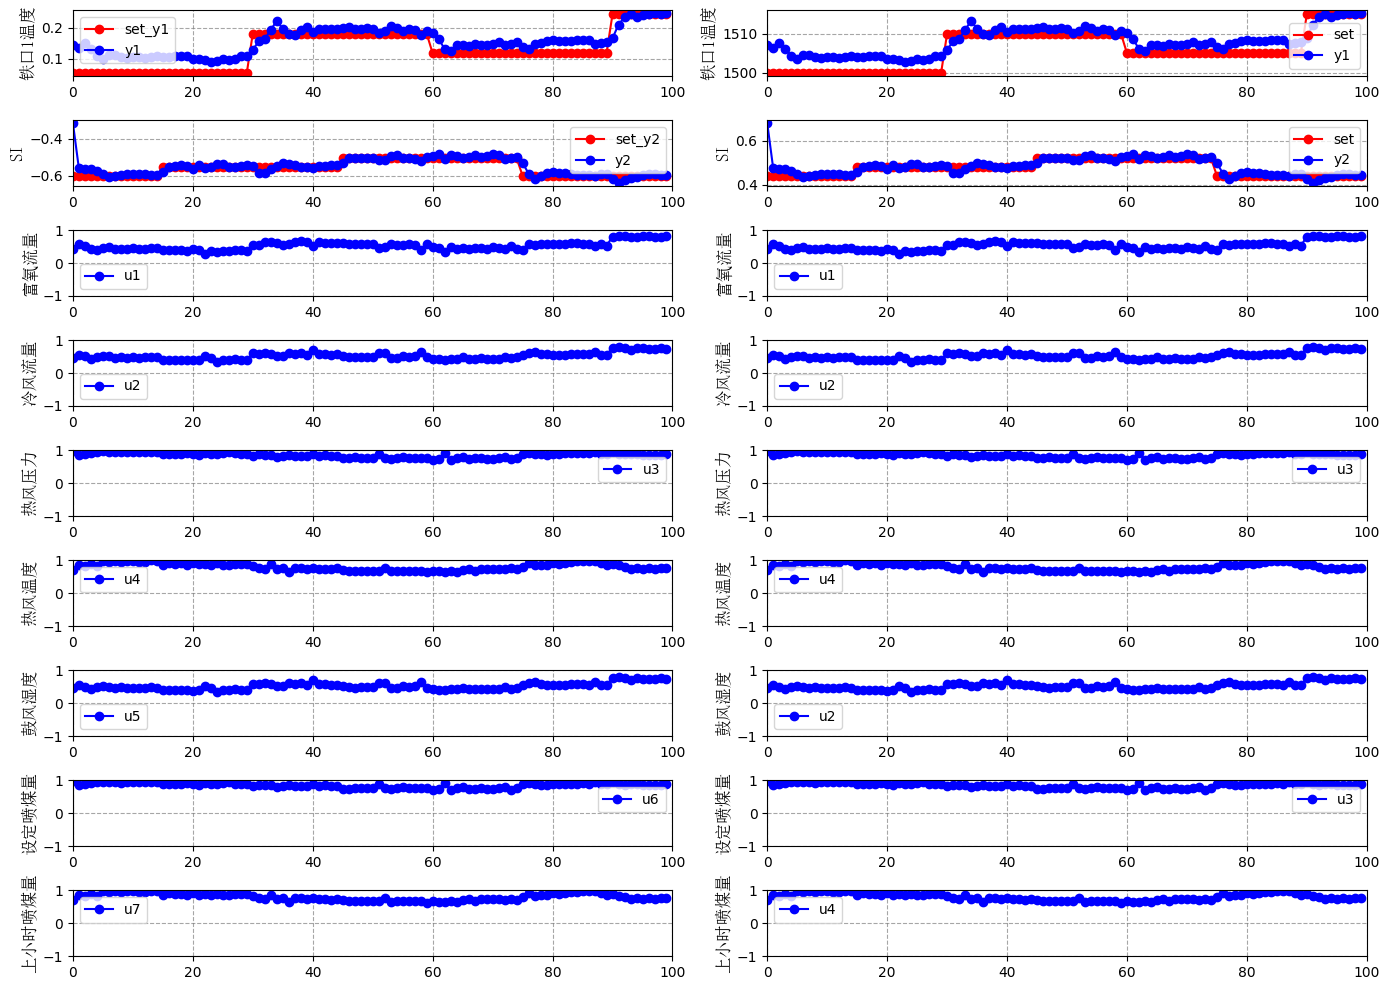

In [28]:
# 数据转换、
data_tranform_plot(scalers,Times ,max_control,
                        output_term,input_term,
                        set_y1,set_y2,set_y1_trans,set_y2_trans,
                        all_pred_y1, all_pred_y2,
                        all_pred_u1,
                        all_pred_u2,
                        all_pred_u3,
                        all_pred_u4)
